<a href="https://colab.research.google.com/github/bori00/BreastCancerSegmentation/blob/main/Breast_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

* Dataset: https://github.com/PathologyDataScience/BCSS
* Paper: https://academic.oup.com/bioinformatics/article/35/18/3461/5307750

## TODO



*   dat augmentation
*   find the right image size
*   set the weight of the 0-class to 0
*   train on the full dataset
*   reset batch size to 32 or similar



# Setup: Importing the libraries and the dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import urllib
from urllib import request

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

import cv2
import os

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
TEST_RATIO = 0.2
SEED = 123
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 2
MAX_DATASET_SIZE = 30

## Load Images. Initial Dataset Construction

In [ ]:
IMAGES_DIRECTORY = '/content/rgbs_colorNormalized';
MASKS_DIRECTORY = '/content/masks'

In [ ]:
!unzip gdrive/MyDrive/PRS_Project/masks-20221122T203004Z-001.zip 
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
!unzip gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip

Archive:  gdrive/MyDrive/PRS_Project/masks-20221122T203004Z-001.zip
replace masks/TCGA-A7-A26F-DX1_xmin72969_ymin11489_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
replace rgbs_colorNormalized/TCGA-OL-A5RW-DX1_xmin5772_ymin6839_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
replace rgbs_colorNormalized/TCGA-A7-A0DA-DX1_xmin43731_ymin18175_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  gdrive/MyDrive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip
replace rgbs_colorNormalized/TCGA-OL-A5D7-DX1_xmin114443_ymin22490_MPP-0.2500.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def load_images_and_masks(images_folder, masks_folder):
    images = []
    masks = []
    dim = (IMG_WIDTH, IMG_HEIGHT)
    for idx, filename in enumerate(os.listdir(images_folder)):
        if idx == MAX_DATASET_SIZE:
          break
        img = cv2.imread(os.path.join(images_folder,filename))
        img = cv2.resize(img, dim)
        mask = cv2.imread(os.path.join(masks_folder, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, dim)
        print("Loaded image {0}: {1}".format(idx, filename))
        if img is not None:
            assert mask is not None
            images.append(img.astype(np.float32))
            masks.append(mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1).astype(np.float32))
    return images, masks

In [ ]:
images, masks = load_images_and_masks(IMAGES_DIRECTORY, MASKS_DIRECTORY)

Loaded image 0: TCGA-A2-A3XX-DX1_xmin69942_ymin41560_MPP-0.2500.png
Loaded image 1: TCGA-AQ-A54N-DX1_xmin32440_ymin26558_MPP-0.2500.png
Loaded image 2: TCGA-A2-A0YE-DX1_xmin59206_ymin33505_MPP-0.2500.png
Loaded image 3: TCGA-AR-A0TU-DX1_xmin88352_ymin23098_MPP-0.2500.png
Loaded image 4: TCGA-GI-A2C9-DX1_xmin20882_ymin11843_MPP-0.2500.png
Loaded image 5: TCGA-E2-A574-DX1_xmin54962_ymin47475_MPP-0.2500.png
Loaded image 6: TCGA-S3-AA15-DX1_xmin55486_ymin28926_MPP-0.2500.png
Loaded image 7: TCGA-A1-A0SP-DX1_xmin6798_ymin53719_MPP-0.2500.png
Loaded image 8: TCGA-AN-A0XU-DX1_xmin26118_ymin18441_MPP-0.2500.png
Loaded image 9: TCGA-EW-A3U0-DX1_xmin113512_ymin48566_MPP-0.2500.png
Loaded image 10: TCGA-LL-A73Y-DX1_xmin68117_ymin49445_MPP-0.2500.png
Loaded image 11: TCGA-AR-A5QQ-DX1_xmin107130_ymin49863_MPP-0.2500.png
Loaded image 12: TCGA-AN-A0G0-DX1_xmin32741_ymin14546_MPP-0.2500.png
Loaded image 13: TCGA-BH-A0BW-DX1_xmin42346_ymin30843_MPP-0.2500.png
Loaded image 14: TCGA-GM-A2DF-DX1_xmin50637

In [ ]:
print("Nr of images read: {0}".format(len(images)))

Nr of images read: 30


In [ ]:
image = images[0]
mask = masks[0]
print("Image shape: {0}; Mask shape: {1}".format(image.shape, mask.shape))

Image shape: (512, 512, 3); Mask shape: (512, 512, 1)


In [ ]:
data = tf.data.Dataset.from_tensor_slices((images, masks))

In [ ]:
print("Total Dataset Size: {0}".format(tf.data.experimental.cardinality(data).numpy()))

Total Dataset Size: 30


## Dataset Split (Train-Validation-Test)

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=1.0 - 2*TEST_RATIO, val_split=TEST_RATIO, test_split=TEST_RATIO, shuffle=True, shuffle_size=10000):
    # source: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data, tf.data.experimental.cardinality(data).numpy())

## Preprocessing (TODO) and Batching

In [ ]:
train_batches = (
    train_ds
    .cache()
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)
test_batches = test_ds.batch(BATCH_SIZE)

## Old Code

In [ ]:
# setting dictionary for the tf_data_dataset parameters
tf_Dataset_args=dict(labels=None,
                     label_mode=None,
                     validation_split=TEST_RATIO,
                     batch_size=BATCH_SIZE,
                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                     seed=SEED
                     )

In [ ]:
# train_images_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_DIRECTORY,
#   **tf_Dataset_args,
#   subset="training").map(toInt)

# test_images_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_DIRECTORY,
#   **tf_Dataset_args,
#   subset="validation").map(toInt)

In [ ]:
# train_masks_ds = tf.keras.utils.image_dataset_from_directory(
#   MASKS_DIRECTORY,
#    **tf_Dataset_args,
#   subset="training").map(toInt)

# test_masks_ds = tf.keras.utils.image_dataset_from_directory(
#    MASKS_DIRECTORY,
#    **tf_Dataset_args,
#   subset="validation").map(toInt)

In [ ]:
# train_set=list(zip(train_images_ds, train_masks_ds))

In [ ]:
# test_set=list(zip(test_images_ds, test_masks_ds))

In [ ]:
# training_data = tf.data.Dataset.from_tensor_slices(train_set)
# test_data = tf.data.Dataset.from_tensor_slices(test_set)

## Loading the Class Definitions

In [ ]:
classes_df = pd.read_csv("gtruth_codes.csv")
classes_df

,label,GT_code
0,outside_roi,0
1,tumor,1
2,stroma,2
3,lymphocytic_infiltrate,3
4,necrosis_or_debris,4
5,glandular_secretions,5
6,blood,6
7,exclude,7
8,metaplasia_NOS,8
9,fat,9


**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model.

# Exploratory Data Analysis

## From the images in the drive folders

In [ ]:
def plot_image_and_mask(image_name):
  plt.figure(figsize=(20, 8))
  plt.suptitle("Image: " + image_name)

  plt.subplot(1, 2, 1)
  mask = mpimg.imread(MASKS_DIRECTORY + image_name)
  plt.imshow(mask)
  plt.title("Mask")
  
  plt.subplot(1, 2, 2)
  image = mpimg.imread(IMAGES_DIRECTORY + image_name)
  plt.imshow(image)
  plt.title("Image")

  plt.show()

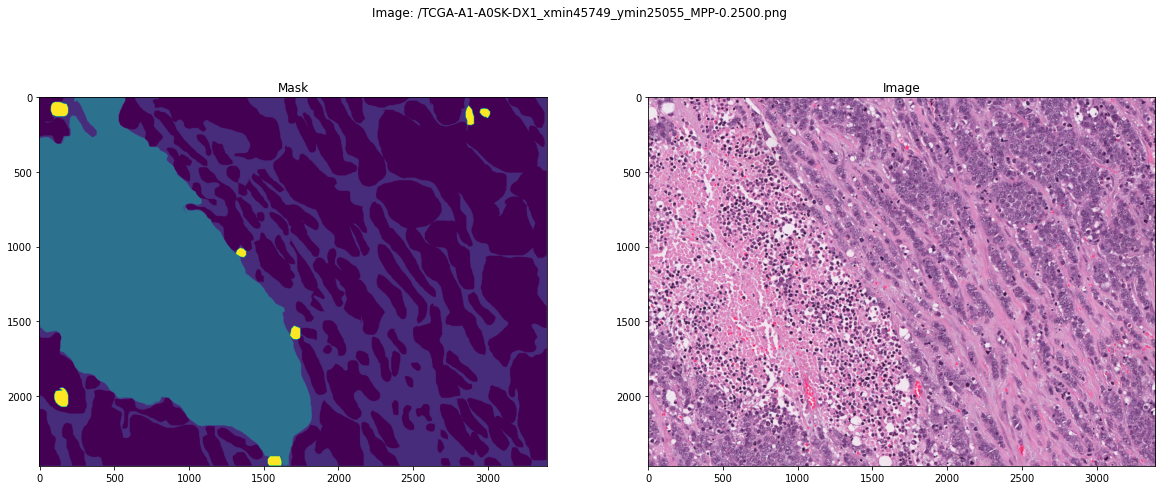

In [ ]:
plot_image_and_mask('/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500.png')

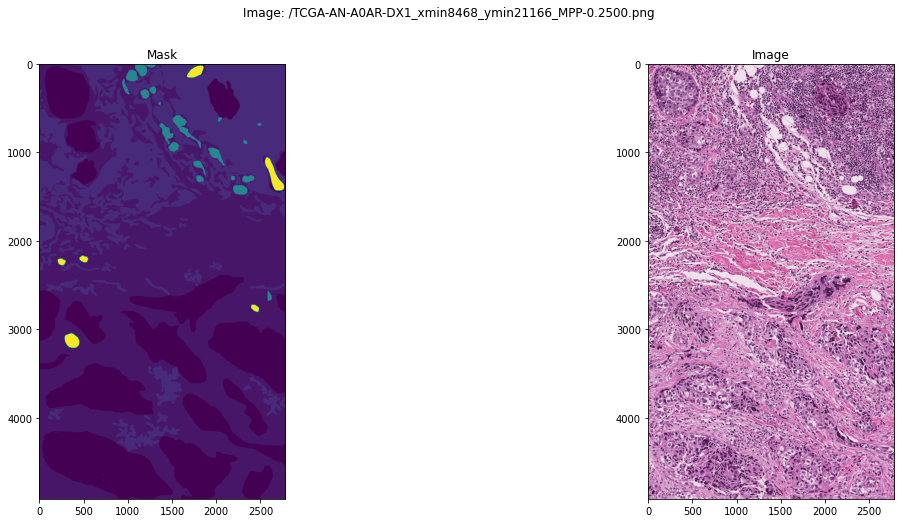

In [ ]:
plot_image_and_mask('/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png')

## From the Dataset

In [ ]:
def display(display_list):
  # source: https://www.tensorflow.org/tutorials/images/segmentation
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Sample Batch in the Training Dataset


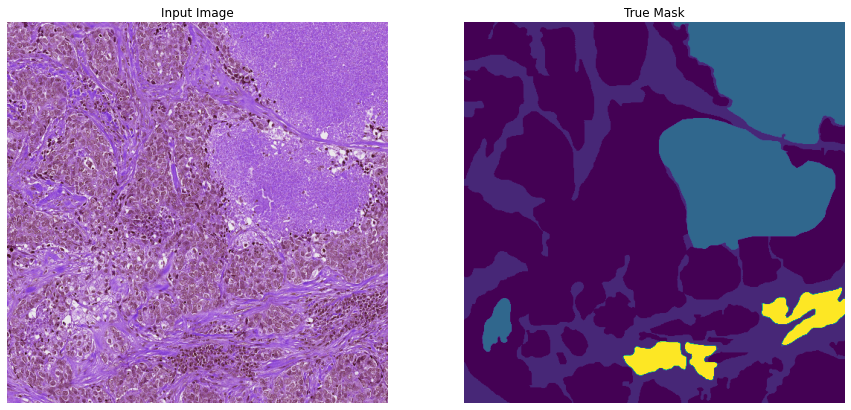

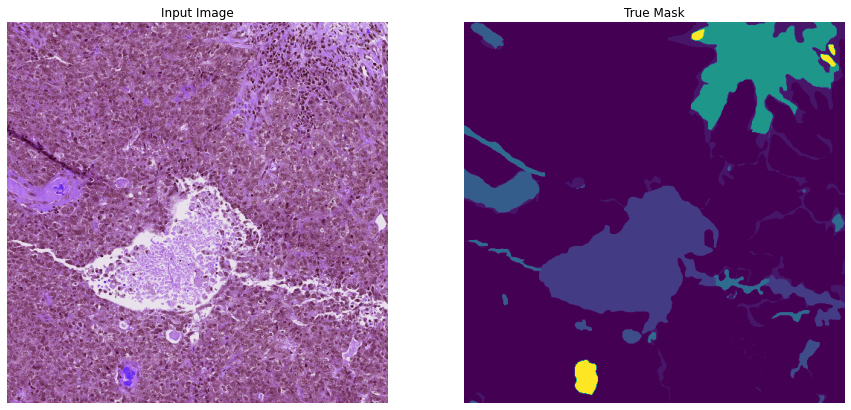

In [ ]:
print("Sample Batch in the Training Dataset")

for image, mask in train_batches.take(1):
  for i in range(image.shape[0]):
    sample_image, sample_mask = images[i], masks[i]
    display([sample_image, sample_mask])

# Initial Model: U-NET

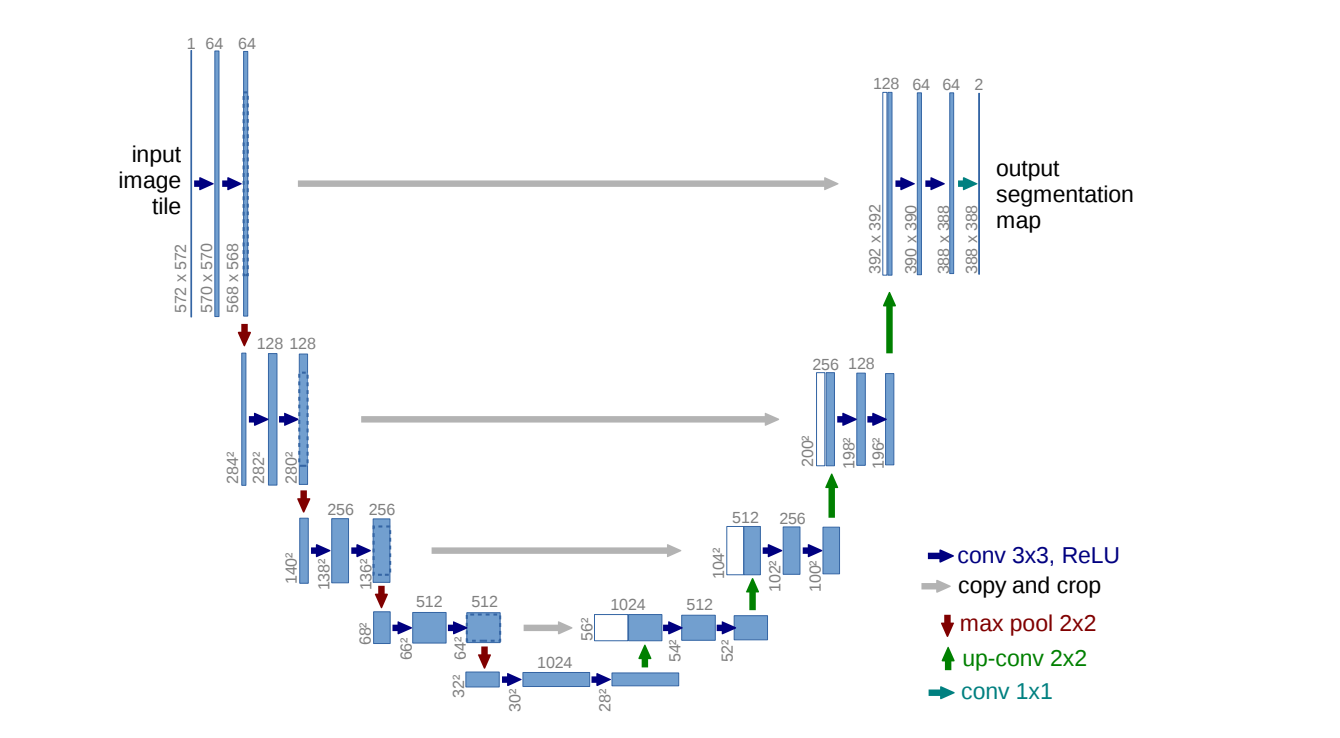

In [ ]:
nr_classes = len(classes_df)

In [ ]:
class UNetDoubleConvBlock(tf.keras.layers.Layer):
  def __init__(self, nr_channels):
    super(UNetDoubleConvBlock, self).__init__()
    self.nr_channels = nr_channels
    self.conv1 = layers.Conv2D(self.nr_channels, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")
    self.conv2 = layers.Conv2D(self.nr_channels, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'doublceConv_nrChannels': self.nr_channels
    })
    return config

  def call(self, input):
    x = self.conv1(input)
    x = self.conv2(x)
    return x

In [ ]:
class UNetEncoderBlock(tf.keras.layers.Layer):
  def __init__(self, nr_channels):
    super(UNetEncoderBlock, self).__init__()
    self.nr_channels = nr_channels
    self.double_conv_block = UNetDoubleConvBlock(nr_channels)
    self.max_pool = layers.MaxPool2D(2)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'UNetEncoderBlock_nrChannels': self.nr_channels
    })
    return config

  def call(self, input):
    f = self.double_conv_block(input)
    p = self.max_pool(f)
    return f, p

In [ ]:
class UNetDecoderBlock(tf.keras.layers.Layer):
  def __init__(self, nr_channels):
    super(UNetDecoderBlock, self).__init__()
    self.nr_channels = nr_channels
    self.upsample = layers.UpSampling2D(size=(2, 2))
    self.max_pool = layers.MaxPool2D(2)
    self.double_conv_block = UNetDoubleConvBlock(nr_channels)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'UNetDecoderBlock_nrChannels': self.nr_channels
    })
    return config

  def call(self, input):
    up_input, forward_input = input
    up_input = self.upsample(up_input)
    # crop
    crop = int((forward_input.shape[1] - up_input.shape[1]) / 2)
    forward_input = layers.Cropping2D(cropping=crop)(forward_input)
    x = layers.concatenate([up_input, forward_input])
    x = self.double_conv_block(x)
    return x

In [ ]:
class MyUNetModel(tf.keras.Model):

  def __init__(self, nr_classes):
    super(MyUNetModel, self).__init__()
    self.encoder1 = UNetEncoderBlock(64)
    self.encoder2 = UNetEncoderBlock(128)
    self.encoder3 = UNetEncoderBlock(256)
    self.encoder4 = UNetEncoderBlock(512)
    self.bottleneck = UNetDoubleConvBlock(1024)
    self.decoder1 = UNetDecoderBlock(512)
    self.decoder2 = UNetDecoderBlock(256)
    self.decoder3 = UNetDecoderBlock(128)
    self.decoder4 = UNetDecoderBlock(64)
    self.final_conv = layers.Conv2D(nr_classes, 1, padding="same", activation = "softmax")


  def call(self, inputs, training=False):
    f1, p1 = self.encoder1(inputs)
    f2, p2 = self.encoder2(p1)
    f3, p3 = self.encoder3(p2)
    f4, p4 = self.encoder4(p3)
    p5 = self.bottleneck(p4)
    d1 = self.decoder1([p5, f4])
    d2 = self.decoder2([d1, f3])
    d3 = self.decoder3([d2, f2])
    d4 = self.decoder4([d3, f1])

    output = self.final_conv(d4)

    return output

In [ ]:
unet_model = MyUNetModel(len(classes_df))

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy",
                  run_eagerly=True)

for image, mask in train_batches.take(1):
  input_shape = image[0].shape
input_shape = (None, input_shape[0], input_shape[1], input_shape[2])

unet_model.build(input_shape)

In [ ]:
unet_model.summary()

Model: "my_u_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 u_net_encoder_block (UNetEn  multiple                 38720     
 coderBlock)                                                     
                                                                 
 u_net_encoder_block_1 (UNet  multiple                 221440    
 EncoderBlock)                                                   
                                                                 
 u_net_encoder_block_2 (UNet  multiple                 885248    
 EncoderBlock)                                                   
                                                                 
 u_net_encoder_block_3 (UNet  multiple                 3539968   
 EncoderBlock)                                                   
                                                                 
 u_net_double_conv_block_4 (  multiple              

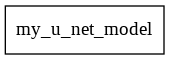

In [ ]:
tf.keras.utils.plot_model(unet_model, show_layer_activations=True, show_dtype=True, 
                       show_layer_names=True, show_shapes=True)

In [ ]:
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))>

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = len(train_ds)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
VAL_LENGTH = len(val_ds)
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20
9/9 [==============================] - 533s 59s/step - loss: 44817.1562 - accuracy: 0.1483
Epoch 2/20
9/9 [==============================] - 529s 59s/step - loss: 13.1686 - accuracy: 0.2606
Epoch 3/20
9/9 [==============================] - 529s 59s/step - loss: 7.8268 - accuracy: 0.2196
Epoch 4/20
9/9 [==============================] - 525s 58s/step - loss: 6.2277 - accuracy: 0.2507
Epoch 5/20
9/9 [==============================] - 530s 58s/step - loss: 3.7698 - accuracy: 0.2537
Epoch 6/20
9/9 [==============================] - 531s 59s/step - loss: 2.9958 - accuracy: 0.1993
Epoch 7/20
9/9 [==============================] - 533s 59s/step - loss: 2.6291 - accuracy: 0.1992
Epoch 8/20
9/9 [==============================] - 532s 59s/step - loss: 2.2641 - accuracy: 0.2592
Epoch 9/20
9/9 [==============================] - 533s 59s/step - loss: 2.0274 - accuracy: 0.2900
Epoch 10/20
9/9 [==============================] - 531s 59s/step - loss: 2.0030 - accuracy: 0.2958
Epoch 11/20
9/